In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_bam_sif import *

In [3]:
gain=3.853           # gain [e-/ADU]
readnoise=8.365785291814616 # readout noise [e-]
bias=2576            # bias [ADU]

In [4]:
# let's process multiple files at once - I want some nicer statistic
# this is a time-ordered file of filenames

pathfile = "../filenames_bam-sif_new.txt"


allfiles = []
f = open(pathfile, 'r')
allfiles = f.readlines()
f.close()

# strip away newlines and add absolute path prefix
allfiles = ["../../"+s.strip() for s in allfiles]

# select sourcefiles for this run

sourcefiles = []


# some random date(s)
#mydates = ["2017-06-30","2017-07-01","2017-07-02","2017-07-03","2017-07-04","2017-07-05","2017-07-06"]
#mydates = ["2017-09-14"]

# get an entire month
#year = 2014   # 2017
#month = 4     # 6
#mydates = ["{}-{:02d}-{:02d}".format(year,month,day) for day in range(32)] # Feb 31 does not exist, but we don't care

#for date in mydates:
#    sourcefiles += [s for s in allfiles if date in s]

    
# heck, just get everything
sourcefiles = allfiles


#sourcefiles = [sourcefiles[1]]  # if I want to use only one file

print("Using", len(sourcefiles), "files")

Using 1484 files


In [5]:
from astropy.io import fits
from scipy.stats import trimboth

Alright, let's prototype something for this.

In [6]:
out0 = []
out1 = []

# time it
import time
tstart = time.time()

# loop over sourcefiles

for ii in range(len(sourcefiles)):
    N_AL = 721
    # read in the data
    source, acqTime = bam_sif_read(sourcefiles[ii], N_AL, gain, bias)
    
    # signal, error and background
    signal, err_sig, background = bam_sif_signal(source, readnoise)
    
    # the cosmics
    #output_0, output_1 = bam_sif_cosmics(signal, err_sig, threshold=5, threshfrac=0.5, N_mask=0, gain=gain, acqTime=acqTime)
    # tweaked parameters from validation
    output_0, output_1 = bam_sif_cosmics(signal, err_sig, threshold=5, threshfrac=0.5, N_mask=0, gain=gain, acqTime=acqTime)
    out0.append(output_0)
    out1.append(output_1)
    
    
tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 92.86063647270203


WOW, we can just do the entire thing at once...

# Writing

In [12]:
# 2014: [0:869]
# 2015: [869:1080]
# 2016: [1080:1343]
# 2017: [1343:]

years = [2014,2015,2016,2017]
borders = [0,869,1080,1343,-1]

# time it
import time
tstart = time.time()

for ii in range(len(years)):
    outfile1 = 'BAM-SIF1_{}.fits'.format(years[ii])
    outfile2 = 'BAM-SIF2_{}.fits'.format(years[ii])
    
    
    write_Obslist(out0[borders[ii]:borders[ii+1]], outfile1)
    write_Obslist(out1[borders[ii]:borders[ii+1]], outfile2)

    
tend = time.time()
print("Elapsed time:", tend - tstart)



Elapsed time: 119.22605633735657


# Some diagnostics

In [22]:
# This should be quite a lot of energies, so do a histogram

E0 = []
E1 = []

# also for lengths, why not
AL0 = []
AL1 = []
AC0 = []
AC1 = []

for ii in range(len(out0)):
    E0 += list(out0[ii].data["TRACK_EN"])
    AL0 += list(out0[ii].data["DIM_AL"]-1)
    AC0 += list(out0[ii].data["DIM_AC"]-1)
    E1 += list(out1[ii].data["TRACK_EN"])
    AL1 += list(out1[ii].data["DIM_AL"]-1)
    AC1 += list(out1[ii].data["DIM_AC"]-1)

E0 = np.array(E0)
E1 = np.array(E1)
AL0 = np.array(AL0)
AC0 = np.array(AC0)
AL1 = np.array(AL1)
AC1 = np.array(AC1)

        
# number of cosmics
print("FOV 0:", len(E0), "cosmics")
print("FOV 1:", len(E1), "cosmics")

FOV 0: 72151 cosmics
FOV 1: 54292 cosmics


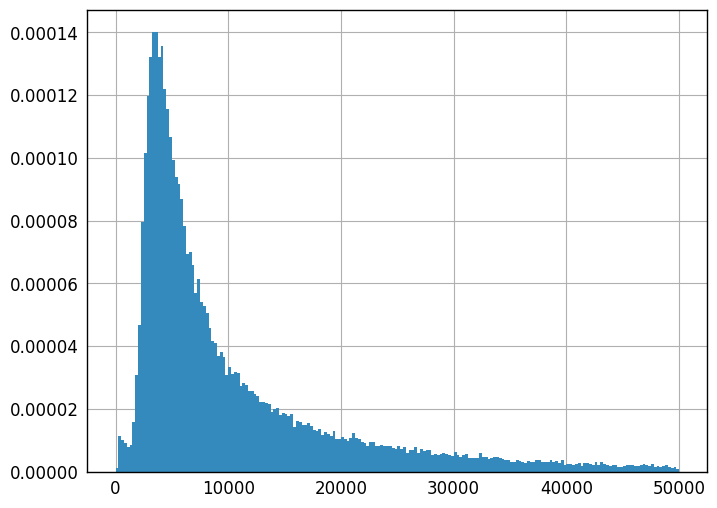

In [23]:
hist0 = plt.hist(E0, 200, log=False ,range=(0,50000), normed=True)

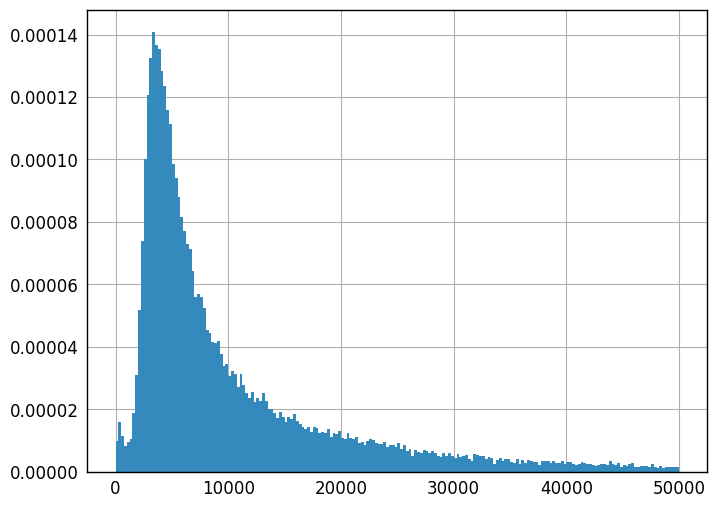

In [24]:
hist1 = plt.hist(E1, 200, log=False ,range=(0,50000), normed=True)

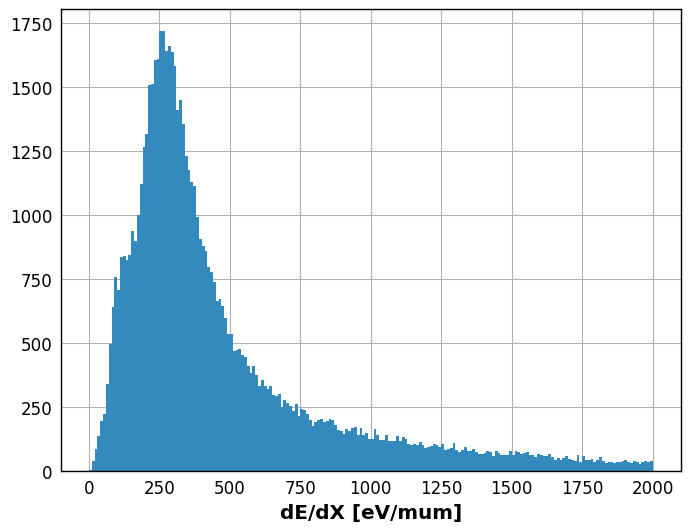

In [25]:
# Let's try dE/dx
lx = AL0*10  # mum
ly = AC0*120 # mum

lengths = np.sqrt(lx*lx + ly*ly)

dEdx = E0/np.sqrt(lengths**2+40**2) # assuming our length measurement is good and we go through the whole detector

dEdx *= 3.6   # energy (eV) per electron/hole pair

thist = plt.hist(dEdx,200,log=False,range=(0,2000))
plt.xlabel("dE/dX [eV/mum]")

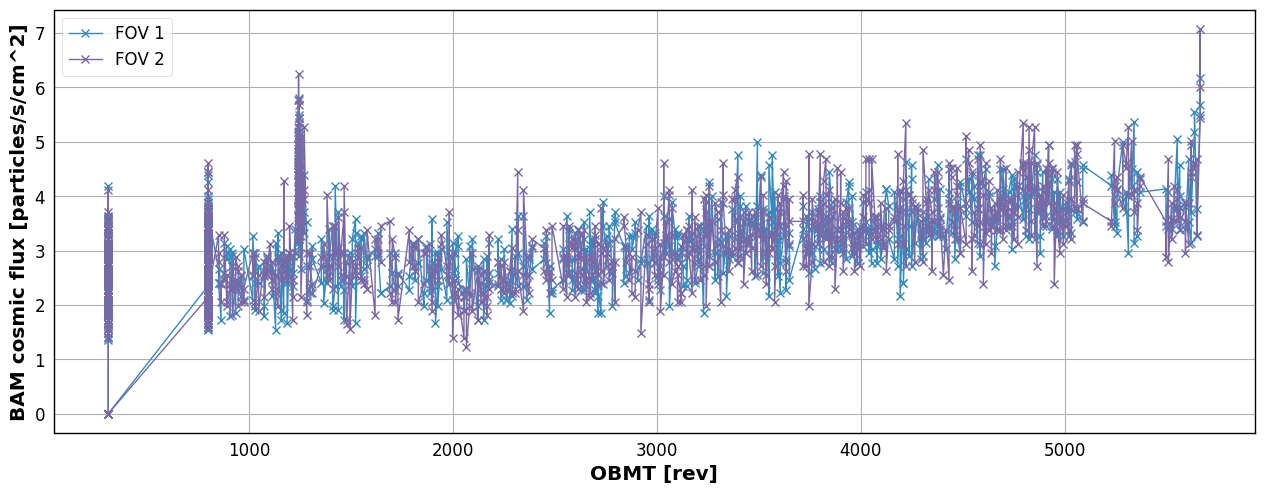

In [15]:
acqTimes = []

for ii in range(len(out0)):
    acqTimes.append(out0[ii].acqTime)
    
acqTimes = np.array(acqTimes)
acqTimes = acqTimes /1e9 / 3600/ 6  # roughly equals revs, no?
#acqTimes = acqTimes /1e9 / 3600/ 24/ 365  # years since start, basically
# both fov have the same acqTime



# fluxes
flux0 = [obs.calculate_flux()[0] for obs in out0]
flux1 = [obs.calculate_flux()[0] for obs in out1]
#flux0 = [len(obs.data) for obs in out0]
#flux1 = [len(obs.data) for obs in out1]


plt.plot(acqTimes,flux0,marker='x',linestyle='-',label="FOV 1")
plt.plot(acqTimes,flux1,marker='x',linestyle='-',label="FOV 2")
plt.xlabel("OBMT [rev]")
plt.ylabel("BAM cosmic flux [particles/s/cm^2]")
plt.legend(loc="best")
#plt.gcf().set_size_inches(30.5, 5.5)
plt.gcf().set_size_inches(15.5, 5.5)

In [30]:
obs = out0[-1]

print(len(obs.data))

92


In [31]:
# for fun - make a cosmic ray image from a TrackObs

image = np.zeros((obs.srcAL,obs.srcAC))

for ii in range(len(obs.data)):
    track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
    start_AL = obs.data[ii]["LOC_AL"]
    stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
    start_AC = obs.data[ii]["LOC_AC"]
    stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
    image[start_AL:stop_AL,start_AC:stop_AC] += track

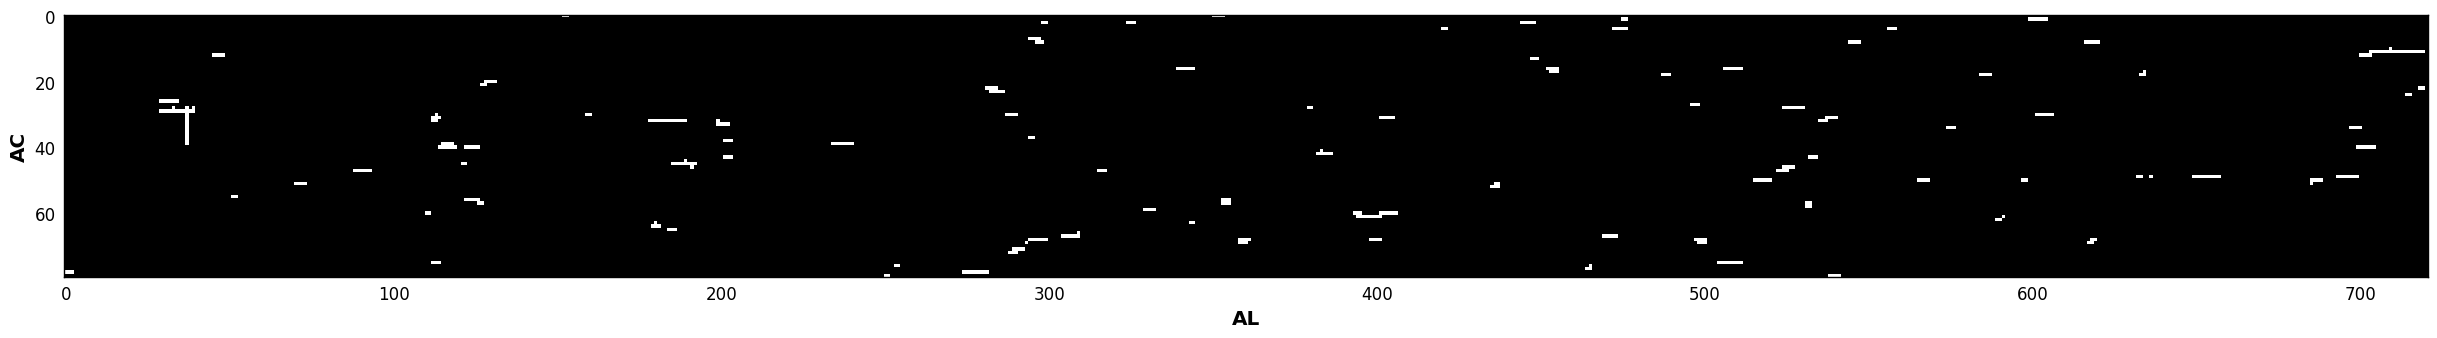

In [32]:
im=np.rot90(image,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='gray',vmax=20)#,aspect=12)
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

FOV 2 has some strange glitches towards the edge - probably the stray light that ralf talked about